__3D TECHNOLOGIES__

__REPORT: On Reducing Maintenance Cost__


__Elaborated by: Sergio Nieto__

__Objective__

This document is a report on the work done by *The Data Science Team* building a predictive model using machine learning to predict the probability of a device failure. 

__Context__

The data is about a fleet of devices transmitting daily aggregated telemetry
attributes.
Predictive maintenance techniques are designed to help determine the condition of in-service equipment in order to predict when maintenance should be performed. This approach promises cost savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

In [158]:
# The libraries we'll use in this report are:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as dt
import matplotlib.lines as mlines
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings('ignore')
sns.set()

# Processing
from sklearn.preprocessing import FunctionTransformer,MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV, StratifiedKFold,cross_val_predict,cross_val_score,ShuffleSplit
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression,  LassoCV
import lightgbm as lgb

# Bayesian Modelling
import pymc3 as pm
import arviz as az
from collections import OrderedDict
import theano
import theano.tensor as tt
import itertools

# Deep Learning

# Evaluation
from sklearn.metrics import roc_curve,auc, roc_auc_score,accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, balanced_accuracy_score,precision_score,average_precision_score




plt.rcParams['figure.figsize'] = (20, 10)
pd.set_option('display.max_columns', None)


In [2]:
np.random.seed(0)

In [3]:
# We check that it is a csv file
# cat device_failure.csv | head 
# shows no problem
# since we know nothing about the file encoding, latin-1 will be used.

## Exploratory Data Analysis 

In [4]:
devices = pd.read_csv("device_failure.csv", encoding='Latin-1')

In [5]:
devices.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [6]:
# Number of different devices

devices.device.nunique()

1169

In [7]:
# How many different dates?

devices.date.nunique()

304

In [8]:
# Not all devices have the same number of records
# This may be a disadvantage for a time series approach to detecting failure

# we take to examples from the previous head:

devices[devices.device == "S1F01085"]["date"].nunique()

6

In [9]:
devices[devices.device == "S1F01E6Y"]["date"].nunique()

48

In [10]:
# Before proceeding, we look at the info in the data frame:

devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [11]:
# We have more than 100 thounsand records, but haw many are failures?

devices.failure.value_counts(normalize=False)

0    124388
1       106
Name: failure, dtype: int64

In [12]:
# Date are converted to datetime from pandas in case we need to use later on these functionality

devices["date"]=pd.to_datetime(devices["date"])

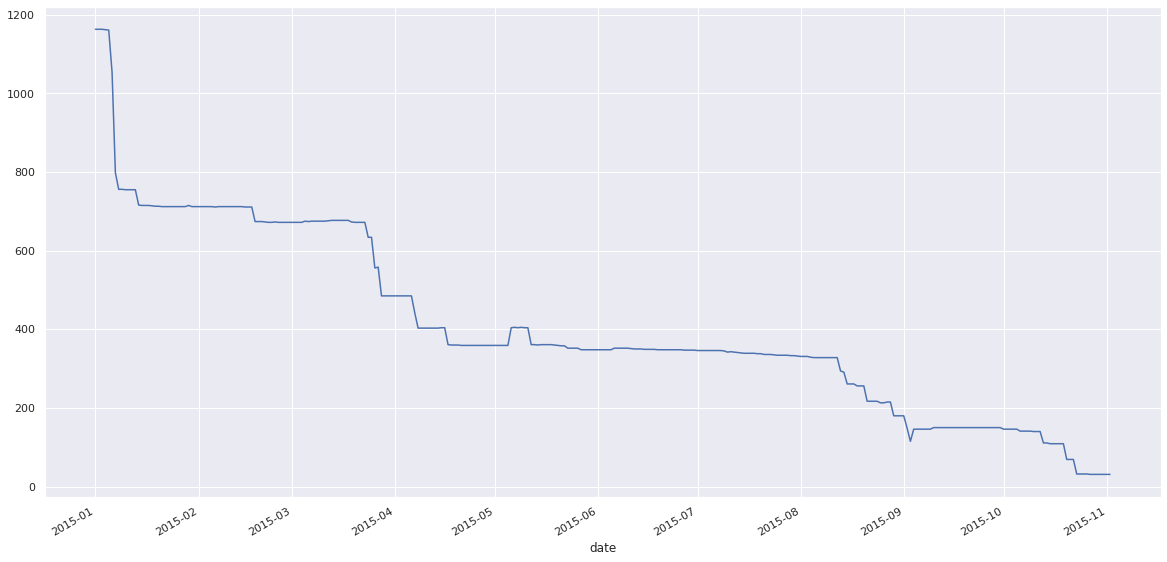

In [13]:
# Since we know

devices.groupby(["date"])["device"].nunique().plot()

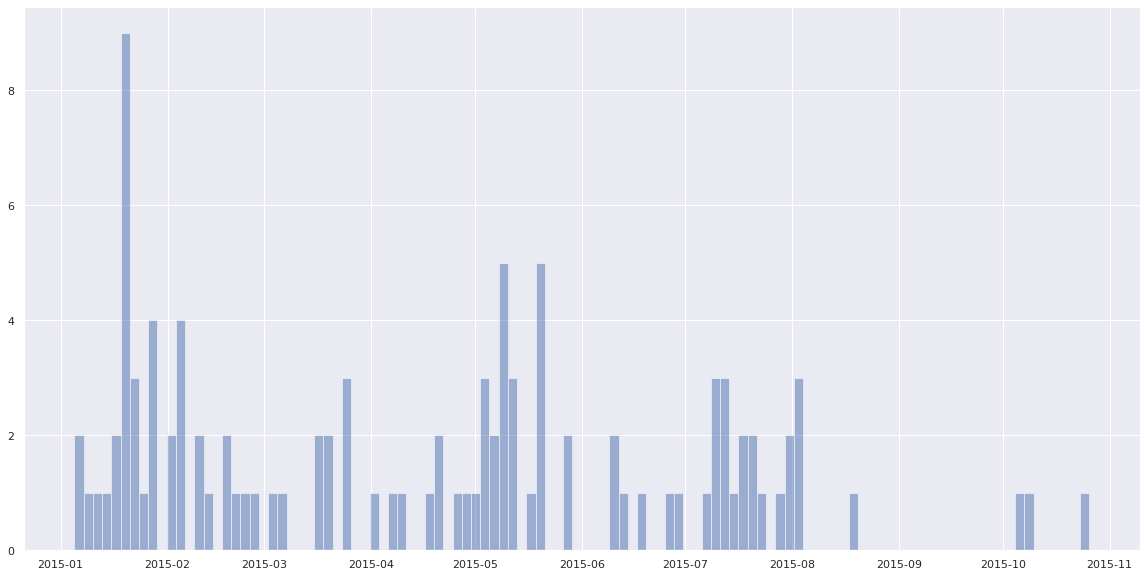

In [14]:
devices.query("(failure == 1)").date.hist(bins = 110, alpha = 0.5)

In [15]:
devices.groupby(["device"])["date"].count().describe()

count    1169.000000
mean      106.496151
std       102.651601
min         1.000000
25%         6.000000
50%        84.000000
75%       224.000000
max       304.000000
Name: date, dtype: float64

__Create a data frame based only on failures to understand better the structure of the time series__

In [26]:
list_failures=list(set(devices[devices.failure == 1]['device']))
devices.loc[devices.device.isin(list_failures),"tag"] = 1
devices.loc[~devices.device.isin(list_failures),"tag"] = 2

In [43]:
failures = devices[devices.tag == 1]
non_failures = devices[devices.tag == 2]

In [44]:
non_failures.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,2.0
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,2.0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,2.0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,2.0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,2.0


In [28]:
failures.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
7,2015-01-01,S1F023H2,0,141503600,0,0,1,19,494462,16,16,3,1.0
23,2015-01-01,S1F03YZM,0,55587136,0,0,0,7,199132,0,0,0,1.0
44,2015-01-01,S1F09DZQ,0,12568128,136,0,2,6,380112,0,0,2,1.0
63,2015-01-01,S1F0CTDN,0,50147888,528,0,4,9,381198,32,32,3,1.0
74,2015-01-01,S1F0DSTY,0,8471680,0,0,0,11,436682,0,0,0,1.0


In [29]:
failures.device.nunique()

106

In [30]:
failures.groupby("device").date.describe().reset_index()

,device,count,unique,top,freq,first,last
0,S1F023H2,19,19,2015-01-04,1,2015-01-01,2015-01-19
1,S1F03YZM,215,215,2015-07-19,1,2015-01-01,2015-08-03
2,S1F09DZQ,199,199,2015-01-31,1,2015-01-01,2015-07-18
3,S1F0CTDN,7,7,2015-01-04,1,2015-01-01,2015-01-07
4,S1F0DSTY,45,45,2015-02-01,1,2015-01-01,2015-02-14
...,...,...,...,...,...,...,...
101,Z1F1901P,132,132,2015-01-07,1,2015-01-01,2015-05-12
102,Z1F1AG5N,9,9,2015-01-04,1,2015-01-01,2015-05-08
103,Z1F1FCH5,19,19,2015-01-04,1,2015-01-01,2015-01-19
104,Z1F1RJFA,124,124,2015-01-07,1,2015-01-01,2015-05-04


In [45]:
failures_desc = failures.groupby("device").date.describe().reset_index()
failures_desc.drop(["count","unique","top","freq"], axis=1, inplace=True)
non_failures_desc = non_failures.groupby("device").date.describe().reset_index()
non_failures_desc.drop(["count","unique","top","freq"], axis=1, inplace=True)
failures_desc.head()

,device,first,last
0,S1F023H2,2015-01-01,2015-01-19
1,S1F03YZM,2015-01-01,2015-08-03
2,S1F09DZQ,2015-01-01,2015-07-18
3,S1F0CTDN,2015-01-01,2015-01-07
4,S1F0DSTY,2015-01-01,2015-02-14


In [41]:
failures_desc["first"].describe()

count                     106
unique                      1
top       2015-01-01 00:00:00
freq                      106
first     2015-01-01 00:00:00
last      2015-01-01 00:00:00
Name: first, dtype: object

In [48]:
failures_desc.head()

,device,first,last
0,S1F023H2,2015-01-01,2015-01-19
1,S1F03YZM,2015-01-01,2015-08-03
2,S1F09DZQ,2015-01-01,2015-07-18
3,S1F0CTDN,2015-01-01,2015-01-07
4,S1F0DSTY,2015-01-01,2015-02-14


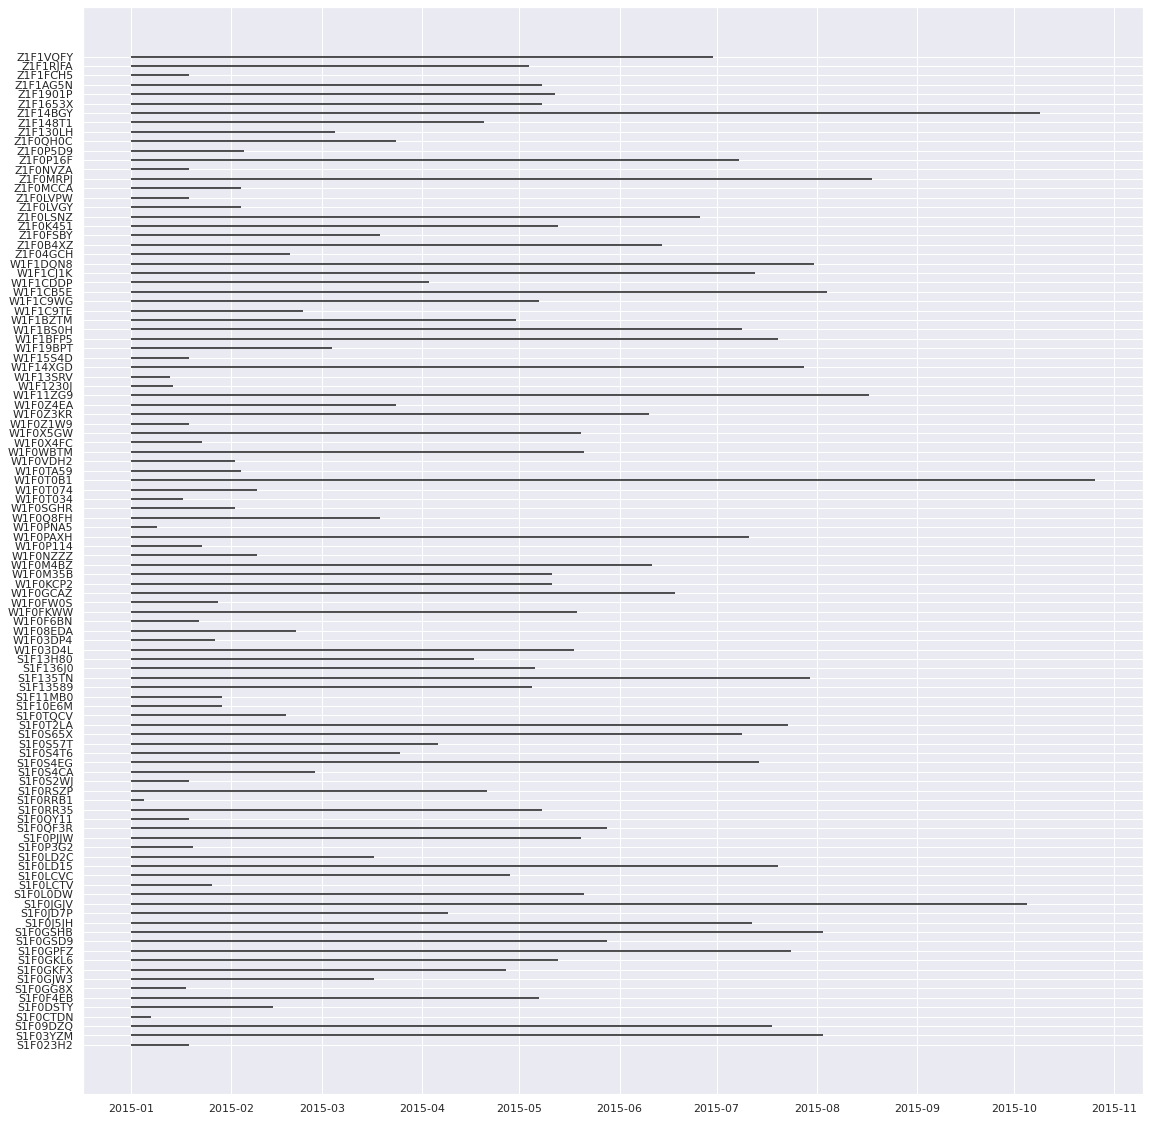

In [53]:
df = failures_desc.rename(columns={'device':'device',
                          'first':'Initial',
                          'last':'Final'})

fig = plt.figure(figsize=(19,20))
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(df.device, dt.date2num(df.Initial), dt.date2num(df.Final))

In [59]:
failures[failures.device == "S1F0RRB1"]

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,tag
235,2015-01-01,S1F0RRB1,0,5230888,2288,0,37,8,39267,24,24,1,1.0
1398,2015-01-02,S1F0RRB1,0,13307628,64776,0,49,8,39267,56,56,1,1.0
2561,2015-01-03,S1F0RRB1,0,26258330,64776,0,135,8,39267,56,56,1,1.0
3724,2015-01-04,S1F0RRB1,0,37985862,64776,0,763,8,39267,56,56,1,1.0
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,56,1,1.0


We do not have a regular pattern over a date range, failures can happen at week 2 or any other week. We cannot take this problem with a time series perspective since it'll have the property that predictions will be based on a window with only a week maybe two as history and the need to drop observations.

As a first conclusion, we have to treat this problem as a supervised machine learning problem, in particular a binary classification task on the target variable 'failure'.

## Data Processing and Feature selection

In [70]:
process_cols = ['attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8','attribute9']

In [71]:
# A descriptive analysis will help to understand relation between variables
# 
devices[process_cols].describe()

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [64]:
## It seems we have two very similar variables: attribute7 and attribute8

In [72]:
# We can also look at linear correlation between variables:

corr = devices[process_cols].corr(method = "spearman") 
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
attribute1,1.000,-0.004,0.004,0.002,-0.003,-0.002,0.000,0.000,0.001
attribute2,-0.004,1.000,-0.003,0.147,-0.014,-0.026,0.141,0.141,-0.003
attribute3,0.004,-0.003,1.000,0.097,-0.007,0.009,-0.002,-0.002,0.532
attribute4,0.002,0.147,0.097,1.000,-0.010,0.025,0.046,0.046,0.036
attribute5,-0.003,-0.014,-0.007,-0.010,1.000,-0.017,-0.009,-0.009,0.006
attribute6,-0.002,-0.026,0.009,0.025,-0.017,1.000,-0.012,-0.012,0.021
attribute7,0.000,0.141,-0.002,0.046,-0.009,-0.012,1.000,1.000,0.007
attribute8,0.000,0.141,-0.002,0.046,-0.009,-0.012,1.000,1.000,0.007
attribute9,0.001,-0.003,0.532,0.036,0.006,0.021,0.007,0.007,1.000


In [120]:
# We can also look at linear correlation between variables:

corr = devices[process_cols].corr(method = "spearman") 
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute8,attribute9
attribute1,1.000,-0.001,0.002,0.002,-0.005,-0.003,-0.002,-0.003
attribute2,-0.001,1.000,-0.019,0.225,-0.027,-0.077,0.109,-0.029
attribute3,0.002,-0.019,1.000,0.121,0.107,0.070,-0.010,0.390
attribute4,0.002,0.225,0.121,1.000,-0.021,0.012,0.163,0.049
attribute5,-0.005,-0.027,0.107,-0.021,1.000,0.084,-0.020,0.034
attribute6,-0.003,-0.077,0.070,0.012,0.084,1.000,-0.016,0.090
attribute8,-0.002,0.109,-0.010,0.163,-0.020,-0.016,1.000,-0.018
attribute9,-0.003,-0.029,0.390,0.049,0.034,0.090,-0.018,1.000


We can see a very important issue here: attribute7 and attribute8 have correlation 1 and the same distribution. 

Most likely they are equal, but still no new information will be generated by keeping both variables.

In [78]:
devices.drop(columns=["attribute7"], axis=1, inplace=True)

# And we remove it also from the list of attributes for processing

process_cols.remove('attribute7')

In [80]:
# We can look now to linear correlation between variables and the target:

devices.corr()['failure'].sort_values(ascending=False)

failure       1.000000
attribute8    0.119055
attribute4    0.067398
attribute2    0.052902
attribute5    0.002270
attribute1    0.001983
attribute9    0.001622
attribute6   -0.000550
attribute3   -0.000948
tag          -0.095136
Name: failure, dtype: float64

__Feature Selection__

 Before we proceed to selection method, attributes need to be standarized since ranges differ from each other and this will cause truble with selection by logistic regression.

In [91]:
# We create two pipelines for processing data so that we have them available for later use:

# We reserve PCA pipeline if needed.

num_pipeline = Pipeline([
    ("estandarizador", StandardScaler())
])


pca_pipeline = ColumnTransformer([
    ("cont", num_pipeline, process_cols)#,
    #("pcas", PCA(n_components = 1, random_state=2020), process_cols)
])

In [92]:
df_num = pca_pipeline.fit_transform(devices)

In [103]:
std_cols = ['x1', 'x2', 'x3' , 'x4', 'x5', 'x6', 'x7' , 'x8']

In [95]:
df_num = pd.DataFrame(df_num, columns=['x1', 'x2', 'x3' , 'x4', 'x5', 'x6', 'x7' , 'x8'])

In [99]:
df_num["y"] = devices["failure"]

In [100]:
df_num.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,1.323358,-0.047478,-0.053516,2.193905,-0.515755,1.485268,-0.039335,-0.028479,0
1,-0.865998,-0.073170,-0.037365,-0.076004,-0.515755,1.442263,-0.039335,-0.065047,0
2,0.722517,-0.073170,-0.053516,-0.076004,-0.139414,-0.229738,-0.039335,-0.065047,0
3,-0.605942,-0.073170,-0.053516,-0.076004,-0.515755,1.512983,-0.039335,-0.065047,0
4,0.192770,-0.073170,-0.053516,-0.076004,0.048757,0.534543,-0.039335,-0.049375,0


In [110]:
X = df_num[std_cols].values
Y = df_num.y

In [167]:
poly = PolynomialFeatures(interaction_only=True)
X_int = poly.fit_transform(X)

In [168]:
selector = SelectFromModel(estimator=LogisticRegression(class_weight='balanced',
                                                        max_iter=200,
                                                        random_state=2020), 
                           threshold = 'median').fit(X_int, Y)
selector.estimator_.coef_

array([[-0.49533753,  0.18914722,  1.24371904, -5.52573988,  0.84532227,
        -0.23263094,  0.28724526,  1.48718155, -1.41304512, -0.11276852,
         1.85475531, -0.28057735,  0.17412718, -0.01439656,  0.44078069,
         1.52082723, -0.29364314, -0.02108822,  0.97060255,  0.91767086,
        -0.41926479,  1.03249105, -3.81830848, -6.05914619,  4.65637122,
        -0.47385241, -0.50548736,  0.65569993, -0.77778383,  0.14528875,
        -3.29678448,  0.39791156,  0.45544156, -1.15487165,  0.18035603,
        -0.51614393, -0.13894346]])

In [169]:
selector.get_support()

array([False, False,  True,  True,  True, False, False,  True,  True,
       False,  True, False, False, False, False,  True, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True, False,  True, False, False,  True, False,  True,
       False])

In [170]:
selector.threshold_

0.5054873617015109

We have a second conclusion: by feature selection with a logistic regression, we can drop the nearly uniformly distributed variable: attribute1 and others that show almost no correlation to the target. 

This is only a way to select a *strategy*: first we'll try with all the variables and only drop the ones we detect here to get better performance.

A third conclusion is the need for *interactions*, these mean nonlinear relation between attributes to help predicting the target. This points us in the following direction: we can try again logistic regression, but better fitted, with the interactions in mind and perhaps try to fit a model using bayesian techniques to quantify uncertainty in the coefficients. 

Another direction to take thes nonlinear relations into account is the use of tree-based algorithms.

So, now we can draw a strategy for modelling: we'll try logit as benchmark and from there we can search for tree-based algorithms. Since nonlinear relations seem to be in the play, we can also try neural network architecture to solve our classification task.

# Modelling: Benchmark

In [ ]:
###################
# Variable Objetivo 
y = df.pkbuena
###################

click.echo("Creando conjuntos de entrenamiento y prueba")
# 
X_train, X_test, y_train, y_test = train_test_split(df[train_cols],y,
                                                    test_size=0.25, random_state=2020)
# En este caso se aplica pipeline de reducción dimensional
X_train_prep = pca_pipeline2.fit_transform(X_train)
X_test_prep = pca_pipeline2.fit_transform(X_test)
#################################################

click.echo("Balanceo de conjuntos")

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train_prep, y_train.ravel())

pipe_rf = Pipeline([('classifier' , RandomForestClassifier(random_state=20200611))])


pipe_gb = Pipeline([('classifier' , GradientBoostingClassifier(random_state=20200611))])


#########################
click.echo("Se crea la malla para hiperparámetros de RF")
##########################


param_grid_rf = [
    {'classifier' : [RandomForestClassifier(random_state=20200611,
    criterion="gini", max_features="auto", oob_score= True,
                                        class_weight="balanced" )],
    'classifier__n_estimators' : list(range(380,581,20)),
    'classifier__max_depth' : list(range(8,11,1))
    } 
]



param_grid_gb = [
    {'classifier' : [GradientBoostingClassifier(random_state=20200611, 
    validation_fraction=0.1)],
    'classifier__learning_rate' : list(np.logspace(-4.8, -1.2, 8)), 
    'classifier__subsample' : list(np.logspace(-.2, -.01, 5)), 
    'classifier__n_estimators' : list(range(540,601,20)),
    'classifier__max_features' : list(range(7,11,1)),
    'classifier__n_iter_no_change' : list(range(7,11,1))
    }
]


# Se usan 5 para prueba, aunque no es necesario subirle


clf_ode_rf = GridSearchCV(pipe_rf, param_grid = param_grid_rf, cv = 5, verbose=True, n_jobs=-1) #cambiar a 5

clf_ode_gb = GridSearchCV(pipe_gb, param_grid = param_grid_gb, cv = 5, verbose=True, n_jobs=-1) #cambiar a 5

#click.echo("Corriendo grid search para el mejor clasificador RF")
#best_clf_ode_rf = clf_ode_rf.fit(X_train_res, y_train_res)


#click.echo("Corriendo grid search para el mejor clasificador GB")
#best_clf_ode_gb = clf_ode_gb.fit(X_train_res, y_train_res)


# Mejores modelos
#print(best_clf_ode_rf.best_estimator_.get_params()['classifier'])
#print(best_clf_ode_gb.best_estimator_.get_params()['classifier'])


# Métricas
#print('Accuracy en entrenamiento rf',best_clf_ode_rf.score(X_train_prep, y_train))
#print('Accuracy en prueba rf',best_clf_ode_rf.score(X_test_prep, y_test))

#print('Accuracy en entrenamiento gb',best_clf_ode_gb.score(X_train_prep, y_train))
#print('Accuracy en prueba gb',best_clf_ode_gb.score(X_test_prep, y_test))

# Reportes
#click.echo("Reporte de clasificación para el mejor clasificador rf")
#classes_rf = best_clf_ode_rf.predict(X_test_prep)
#print(classification_report(classes_rf, y_test))

#click.echo("Reporte de clasificación para el mejor clasificador gb")
#classes_gb = best_clf_ode_gb.predict(X_test_prep)
#print(classification_report(classes_gb, y_test))
#
# 
# Guardando

#filename_rf = 'ode_model_train_RFreducedvar.pkl'

#pickle.dump(best_clf_ode_rf, open('/pfs/out/ode_model_train_RFreducedvar.pkl', 'wb'))

#click.echo("Modelo RFC con reducción dimensional: {} escrito".format(filename_rf))

#filename_gb = 'ode_model_train_GBreducedvar.pkl'

#pickle.dump(best_clf_ode_gb, open('/pfs/out/ode_model_train_GBreducedvar.pkl', 'wb'))

#click.echo("Modelo GBC con reducción dimensional: {} escrito".format(filename_gb))

# Modelos sin grid search

# Son para comparación

# Transformaciones de variables para entrenamiento

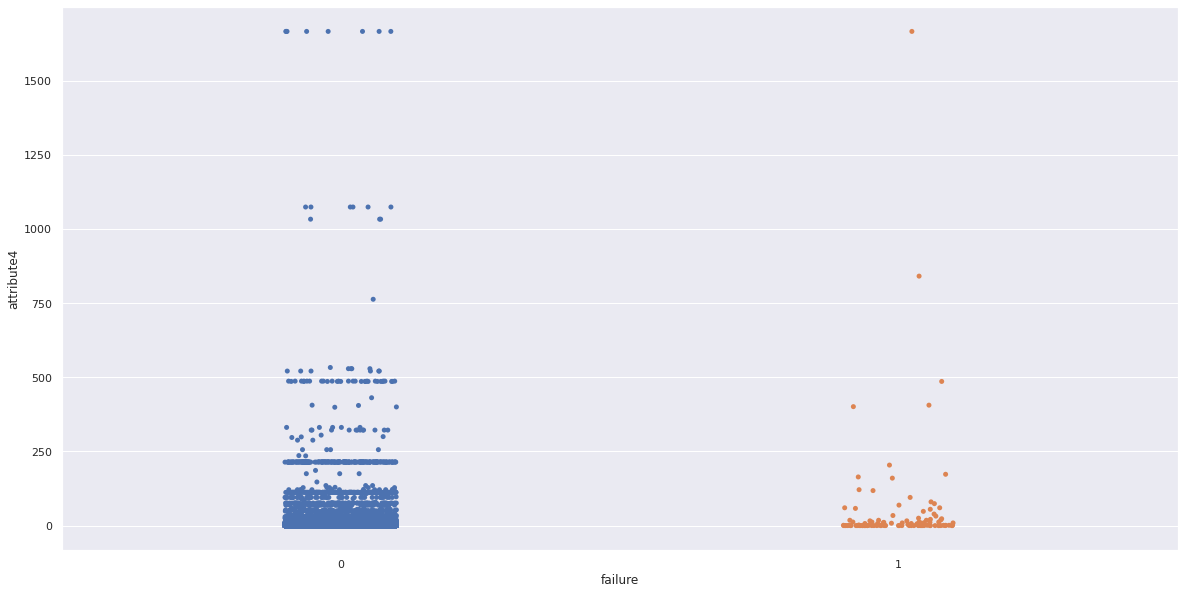

In [82]:
# Correlated variables with target may show some ranges of interest:

sns.stripplot(x="failure", y="attribute4", data=devices, jitter=True)
plt.show();

# Pendientes

### 1. Pca no ha sido probada como opción
### 2. Prototipo: regresión logística con y sin interacciones.
### 3. Paso 2: métodos de árboles
### 4. Paso 3: red neuronal
### 5. Paso 4: Deteccion de anomalías: PCA, SOM SOLO SI DA TIEMPO
### 6. Evaluaciones: tabla comparativa de performance